_**#Performing Descriptive analysis on the transformed data of walmart sales forecast dataset:**_

In [107]:
%%pyspark
#Ingest the transformed data into single dataframe from Azure data lake storage:

df = spark.read.option("inferSchema", "true").option("header", "true").csv(
    [
        'abfss://container_name@storage_account_name.dfs.core.windows.net/Cleaned Data/part-00000-tid-3351946964615847774-2c4f2c50-1ac6-4678-82fe-bed8f4857fba-95-1-c000.csv',
        'abfss://container_name@storage_account_name.dfs.core.windows.net/Cleaned Data/part-00001-tid-3351946964615847774-2c4f2c50-1ac6-4678-82fe-bed8f4857fba-96-1-c000.csv',
        'abfss://container_name@storage_account_name.dfs.core.windows.net/Cleaned Data/part-00002-tid-3351946964615847774-2c4f2c50-1ac6-4678-82fe-bed8f4857fba-97-1-c000.csv',
        'abfss://container_name@storage_account_name.dfs.core.windows.net/Cleaned Data/part-00003-tid-3351946964615847774-2c4f2c50-1ac6-4678-82fe-bed8f4857fba-98-1-c000.csv'
    ],
    header=True
)


StatementMeta(spoolwalmart, 9, 3, Finished, Available, Finished)

In [108]:
#Ensure the schema of the dataset:
df.printSchema()

StatementMeta(spoolwalmart, 9, 4, Finished, Available, Finished)

root
 |-- Store: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Dept: integer (nullable = true)
 |-- Weekly_Sales: double (nullable = true)
 |-- IsHoliday: boolean (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Fuel_Price: double (nullable = true)
 |-- MarkDown1: double (nullable = true)
 |-- MarkDown2: double (nullable = true)
 |-- MarkDown3: double (nullable = true)
 |-- MarkDown4: double (nullable = true)
 |-- MarkDown5: double (nullable = true)
 |-- CPI: double (nullable = true)
 |-- Unemployment: double (nullable = true)
 |-- Type: string (nullable = true)
 |-- Size: integer (nullable = true)



StatementMeta(spoolwalmart, 9, 5, Finished, Available, Finished)

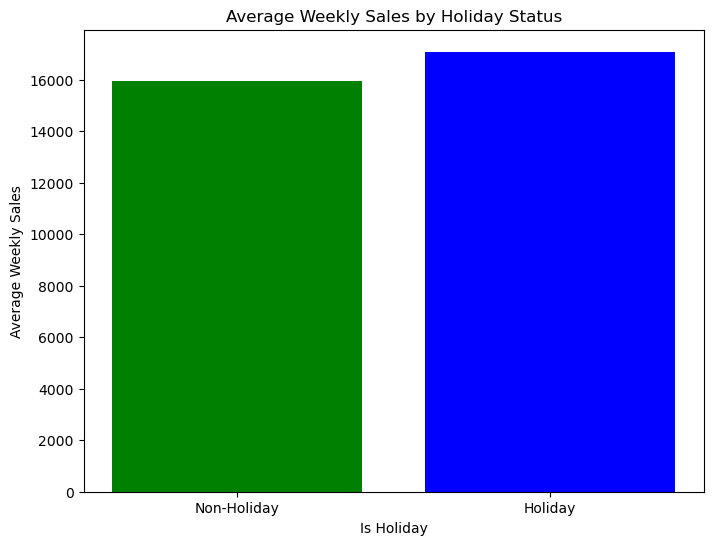

In [109]:
#Analyse the weekly sales inregards to holiday:

#Import the required pyspark lib:
from pyspark.sql.functions import col,avg

# Aggregate the data
avg_sales_by_holiday = df.groupBy("IsHoliday").agg(avg("Weekly_Sales").alias("Average_Sales"))

# This will collect the data into a list of Rows, each Row is a key-value pair
avg_sales_data = avg_sales_by_holiday.collect()

# Extract the categories and their corresponding average sales
categories = [row['IsHoliday'] for row in avg_sales_data]
avg_sales = [row['Average_Sales'] for row in avg_sales_data]

import matplotlib.pyplot as plt

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(categories, avg_sales, color=['blue', 'green'])  # You can customize colors
plt.xlabel('Is Holiday')
plt.ylabel('Average Weekly Sales')
plt.title('Average Weekly Sales by Holiday Status')
plt.xticks(ticks=[0, 1], labels=['Non-Holiday', 'Holiday'])  # Ensure x-ticks represent categories correctly
plt.show()


From the above bar graph it can be observed that the average weekly sales are significantly higher when there is a holiday. Hence, we need to analyse how many holiday weeks are there and what type of holiday occurs on which date according to USA's federal holiday calenders from the specific year.

In [110]:
#Analyse the holiday and non-holiday dates:
from pyspark.sql.functions import col

# Count unique holiday dates
unique_holiday_dates_count = df.filter(col("IsHoliday") == True).select("Date").distinct().count()

# Count unique non-holiday dates
unique_non_holiday_dates_count = df.filter(col("IsHoliday") == False).select("Date").distinct().count()

# Collect unique holiday dates to display
unique_holiday_dates = df.filter(col("IsHoliday") == True).select("Date").distinct().collect()

print(f"Total Unique Holiday Dates: {unique_holiday_dates_count}")
print(f"Total Unique Non-Holiday Dates: {unique_non_holiday_dates_count}")
print("Unique Holiday Dates:")
for date in unique_holiday_dates:
    print(date.Date)  # Assumes 'Date' is stored in a standard date format



StatementMeta(spoolwalmart, 9, 6, Finished, Available, Finished)

Total Unique Holiday Dates: 10
Total Unique Non-Holiday Dates: 133
Unique Holiday Dates:
2010-09-10
2012-09-07
2011-12-30
2012-02-10
2010-11-26
2011-02-11
2011-09-09
2010-02-12
2011-11-25
2010-12-31


So, there are 10 holiday dates and 133 non-holiday dates as analysed from the dataset df. According to the data and calender dates, there are 4 different holidays -> 1) Superbowl , 2) Labor Day , 3) Thanksgiving , 4) Christmas.

In [111]:
#Insert 4 columns for each type of holiday in the df , which will contain boolean values for the dates in the rows:

from pyspark.sql.functions import col, when

# Add 'Super_Bowl' column
df = df.withColumn('Super_Bowl', when(
    (col('Date') == '2010-02-12') | 
    (col('Date') == '2011-02-11') | 
    (col('Date') == '2012-02-10'), True).otherwise(False))

# Add 'Labor_Day' column
df = df.withColumn('Labor_Day', when(
    (col('Date') == '2010-09-10') | 
    (col('Date') == '2011-09-09') | 
    (col('Date') == '2012-09-07'), True).otherwise(False))

# Add 'Thanksgiving' column
df = df.withColumn('Thanksgiving', when(
    (col('Date') == '2010-11-26') | 
    (col('Date') == '2011-11-25'), True).otherwise(False))

# Add 'Christmas' column
df = df.withColumn('Christmas', when(
    (col('Date') == '2010-12-31') | 
    (col('Date') == '2011-12-30'), True).otherwise(False))


df.show(5)

StatementMeta(spoolwalmart, 9, 7, Finished, Available, Finished)

+-----+----------+----+------------+---------+-----------+----------+---------+---------+---------+---------+---------+---------+------------+----+------+----------+---------+------------+---------+
|Store|      Date|Dept|Weekly_Sales|IsHoliday|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|      CPI|Unemployment|Type|  Size|Super_Bowl|Labor_Day|Thanksgiving|Christmas|
+-----+----------+----+------------+---------+-----------+----------+---------+---------+---------+---------+---------+---------+------------+----+------+----------+---------+------------+---------+
|    1|2010-02-05|   1|     24924.5|    false|      42.31|     2.572|      0.0|      0.0|      0.0|      0.0|      0.0|211.09636|       8.106|   A|151315|     false|    false|       false|    false|
|    1|2010-02-12|   1|    46039.49|     true|      38.51|     2.548|      0.0|      0.0|      0.0|      0.0|      0.0|211.24217|       8.106|   A|151315|      true|    false|       false|    false|
|    

StatementMeta(spoolwalmart, 9, 8, Finished, Available, Finished)

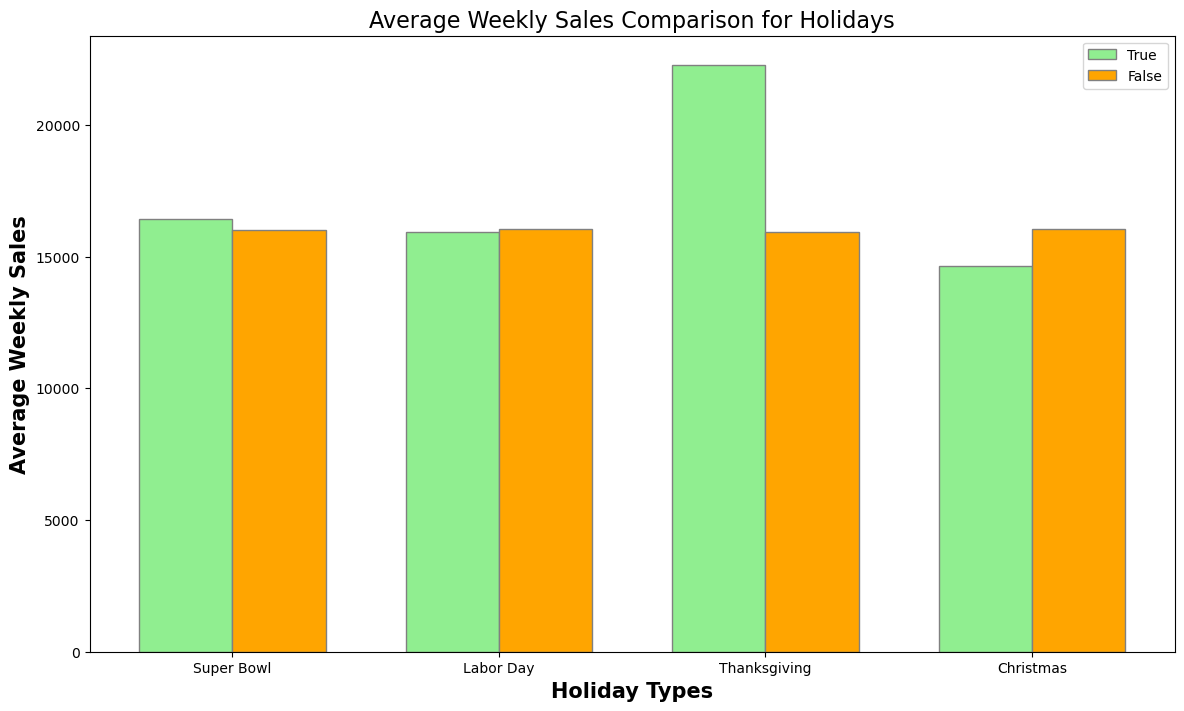

In [112]:
#Visualize the the avg weekly sales according to the type of different holidays:

#aggregate the weekly sales first:
from pyspark.sql.functions import avg

# Calculate average sales for True and False values of each holiday type
def avg_sales_by_holiday(holiday_name):
    return df.groupBy(holiday_name).agg(avg("Weekly_Sales").alias(f"Average_Sales_{holiday_name}"))

# Collect the data for each holiday type
super_bowl_sales = avg_sales_by_holiday("Super_Bowl").toPandas()
labor_day_sales = avg_sales_by_holiday("Labor_Day").toPandas()
thanksgiving_sales = avg_sales_by_holiday("Thanksgiving").toPandas()
christmas_sales = avg_sales_by_holiday("Christmas").toPandas()

import matplotlib.pyplot as plt
import numpy as np

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(14, 8))

# Bar width
bar_width = 0.35

# Positions of the bars on the x-axis
r1 = np.arange(4)
r2 = [x + bar_width for x in r1]

# Data preparation
true_sales = [
    super_bowl_sales[super_bowl_sales['Super_Bowl'] == True]['Average_Sales_Super_Bowl'].values[0],
    labor_day_sales[labor_day_sales['Labor_Day'] == True]['Average_Sales_Labor_Day'].values[0],
    thanksgiving_sales[thanksgiving_sales['Thanksgiving'] == True]['Average_Sales_Thanksgiving'].values[0],
    christmas_sales[christmas_sales['Christmas'] == True]['Average_Sales_Christmas'].values[0]
]

false_sales = [
    super_bowl_sales[super_bowl_sales['Super_Bowl'] == False]['Average_Sales_Super_Bowl'].values[0],
    labor_day_sales[labor_day_sales['Labor_Day'] == False]['Average_Sales_Labor_Day'].values[0],
    thanksgiving_sales[thanksgiving_sales['Thanksgiving'] == False]['Average_Sales_Thanksgiving'].values[0],
    christmas_sales[christmas_sales['Christmas'] == False]['Average_Sales_Christmas'].values[0]
]

# Make the plot
ax.bar(r1, true_sales, color='lightgreen', width=bar_width, edgecolor='grey', label='True')
ax.bar(r2, false_sales, color='orange', width=bar_width, edgecolor='grey', label='False')

# Add labels
ax.set_xlabel('Holiday Types', fontweight='bold', fontsize=15)
ax.set_ylabel('Average Weekly Sales', fontweight='bold', fontsize=15)
ax.set_title('Average Weekly Sales Comparison for Holidays', fontsize=16)
ax.set_xticks([r + bar_width/2 for r in range(4)])
ax.set_xticklabels(['Super Bowl', 'Labor Day', 'Thanksgiving', 'Christmas'])

# Create legend & Show graphic
ax.legend()
plt.show()



From the above graph it can be observed that the average weekly sales does not have any changes due to the Labor day holiday, whereas, Thanksgiving holidays resulted in significant increase in the avg weekly sales in comparison to all the other types of holidays. The christmas holiday resulted in plumetting avg weekly sales. Super Bowl holidays resulted in a little increase in avg weekly sales. From this analysis, it is evident that not all kind of holidays results in increase in sales. It indicates the need to perform analysis of other parameters in the data and time series analysis at the end to forecast the sales.

StatementMeta(spoolwalmart, 9, 9, Finished, Available, Finished)

+----+------------------+------------+
|Type|     Average_Sales|     Holiday|
+----+------------------+------------+
|   B|12467.035502906981|  Super_Bowl|
|   C|10179.271884222471|  Super_Bowl|
|   A|20612.757673550102|  Super_Bowl|
|   B|12084.304641598126|   Labor_Day|
|   A| 20004.26741352722|   Labor_Day|
|   C|   9893.4592575928|   Labor_Day|
|   B| 18733.97400519031|Thanksgiving|
|   A| 27397.77630299048|Thanksgiving|
|   C| 9696.566615905243|Thanksgiving|
|   B|11488.988052401746|   Christmas|
|   A|18310.167538003967|   Christmas|
|   C| 8031.520607082625|   Christmas|
+----+------------------+------------+



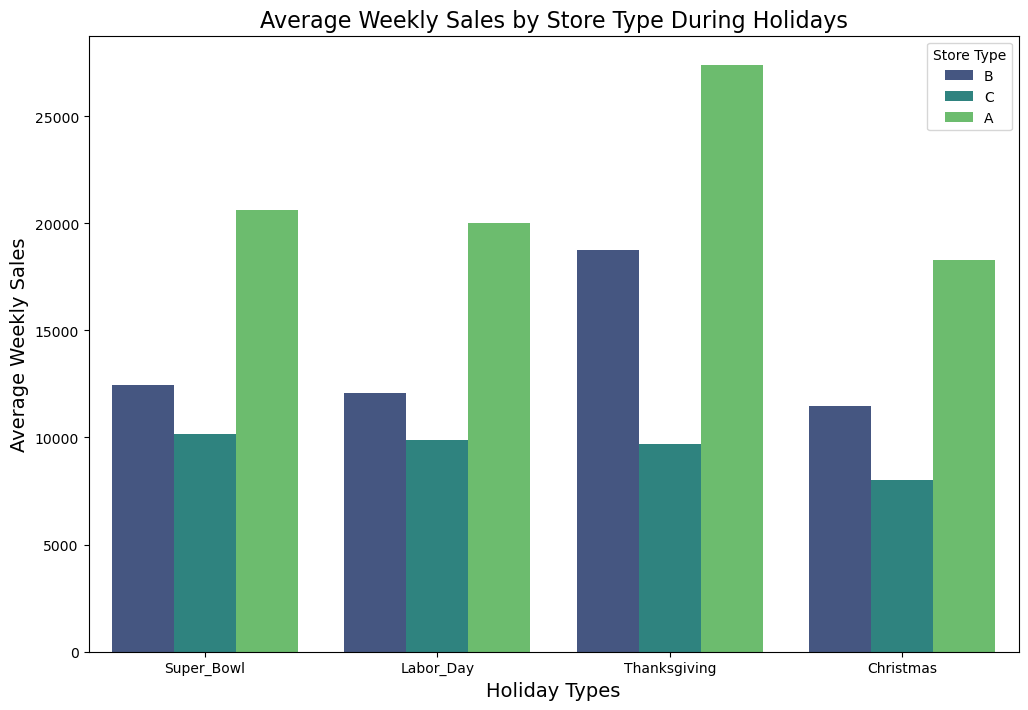

In [113]:
#There are 3 types of stores altogeher, lets analyse the sales for them for all the holidays:
from pyspark.sql.functions import avg, col, lit

# Define the list of holiday columns
holidays = ["Super_Bowl", "Labor_Day", "Thanksgiving", "Christmas"]

# Aggregate data for each holiday
results = []
for holiday in holidays:
    agg_data = df.filter(col(holiday) == True)\
                 .groupBy("Type")\
                 .agg(avg("Weekly_Sales").alias("Average_Sales"))\
                 .withColumn("Holiday", lit(holiday))
    results.append(agg_data)

# Combine results from all holidays into a single DataFrame
from functools import reduce
final_df = reduce(lambda df1, df2: df1.union(df2), results)

# Display the result to confirm it's correct
final_df.show()

# Collect the data to Pandas for visualization
holiday_sales_pd = final_df.toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create a bar plot using seaborn for better color handling and layout
sns.barplot(data=holiday_sales_pd, x='Holiday', y='Average_Sales', hue='Type', palette='viridis')

# Adding labels and title
plt.xlabel('Holiday Types', fontsize=14)
plt.ylabel('Average Weekly Sales', fontsize=14)
plt.title('Average Weekly Sales by Store Type During Holidays', fontsize=16)
plt.legend(title='Store Type')

# Show the plot
plt.show()



From the above graph, it can be observed that, the highest average sales are for Store type A durinf thanksgiving holidays, also Type A store in general has more average weekly sales compared to othher stores. The least average weekly sales are observed for Store Type C during christmas holidays. From this analysis it is indicative that, the store type has significant contribution in  the average weekly sales during the holidays. Also, it leads to the need for analysing the size of the stores.

StatementMeta(spoolwalmart, 9, 10, Finished, Available, Finished)

+----+------+------------------+------------------+-----+------+
|Type| Count|              Mean|            StdDev|  Min|   Max|
+----+------+------------------+------------------+-----+------+
|   A|214961|182225.38509776193|41532.658456655554|39690|219622|
|   B|162787|101796.84423203327|30944.314958059713|34875|140167|
|   C| 42464|40536.097070459684|1194.6944259312077|39690| 42988|
+----+------+------------------+------------------+-----+------+



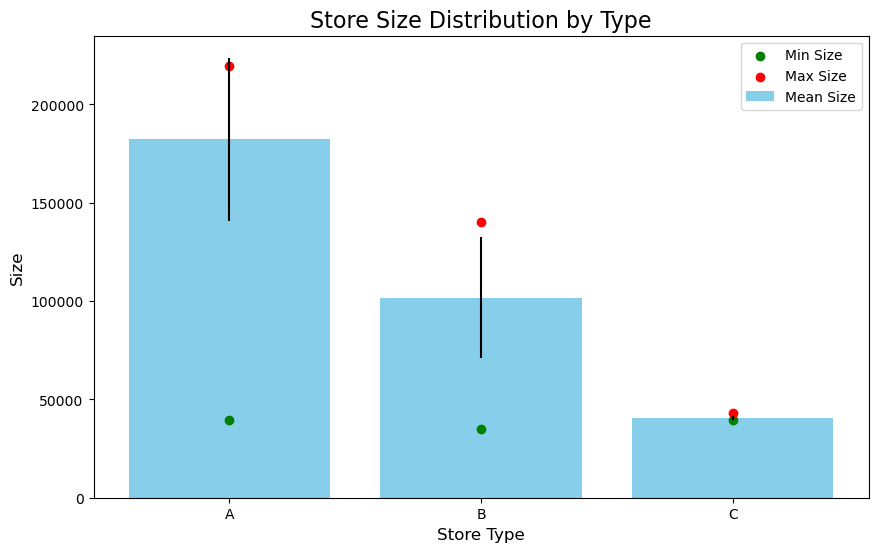

In [114]:
#Lets analyse the size and type relation of the stores.
from pyspark.sql.functions import col, count, mean, stddev, min, max

# Calculate descriptive statistics for 'Size' grouped by 'Type'
stats_df = df.groupBy("Type") \
    .agg(
        count("Size").alias("Count"),
        mean("Size").alias("Mean"),
        stddev("Size").alias("StdDev"),
        min("Size").alias("Min"),
        max("Size").alias("Max")
    ).orderBy("Type")

# Show the results
stats_df.show()

# Convert to Pandas DataFrame
stats_pd = stats_df.toPandas()

import matplotlib.pyplot as plt

# Create a bar plot for the average size
plt.figure(figsize=(10, 6))
plt.bar(stats_pd['Type'], stats_pd['Mean'], color='skyblue', label='Mean Size', yerr=stats_pd['StdDev'])
plt.scatter(stats_pd['Type'], stats_pd['Min'], color='green', label='Min Size')
plt.scatter(stats_pd['Type'], stats_pd['Max'], color='red', label='Max Size')

# Adding labels and title
plt.xlabel('Store Type', fontsize=12)
plt.ylabel('Size', fontsize=12)
plt.title('Store Size Distribution by Type', fontsize=16)
plt.legend()

# Show the plot
plt.show()


From above graph, it cna be observed that the Store Type A is the biggest in size in comparison to other stores, whereas Store type C is the smallest.

StatementMeta(spoolwalmart, 9, 11, Finished, Available, Finished)

+-----+--------------------+--------------------+
|Store|  Total_Weekly_Sales|Average_Weekly_Sales|
+-----+--------------------+--------------------+
|    1| 2.224067667499992E8|  21749.145975943593|
|    2| 2.753871554600002E8|  26961.734429214823|
|    3|5.7587925839999825E7|   6380.226660757791|
|    4|      2.9954526939E8|   29175.54002045388|
|    5| 4.547611971000015E7|  5065.2839953219145|
|    6| 2.237585883699998E8|  21960.799722249463|
|    7| 8.159949582999955E7|   8379.492280755756|
|    8| 1.299515096599997E8|  13148.994198117949|
|    9| 7.779116532999973E7|   8805.882423590641|
|   10|2.7162410941999996E8|   26474.08473879142|
|   11|1.9396439196999976E8|  19332.641480115595|
|   12| 1.442911465499992E8|  14929.244340403437|
|   13| 2.865179502199988E8|   27399.63184660981|
|   14| 2.890018642199988E8|  28885.743550224764|
|   15| 8.913486825999989E7|   9045.551883499074|
|   16| 7.425673509999998E7|   7897.132308837603|
|   17|1.2778318953999981E8|  13023.154253974706|


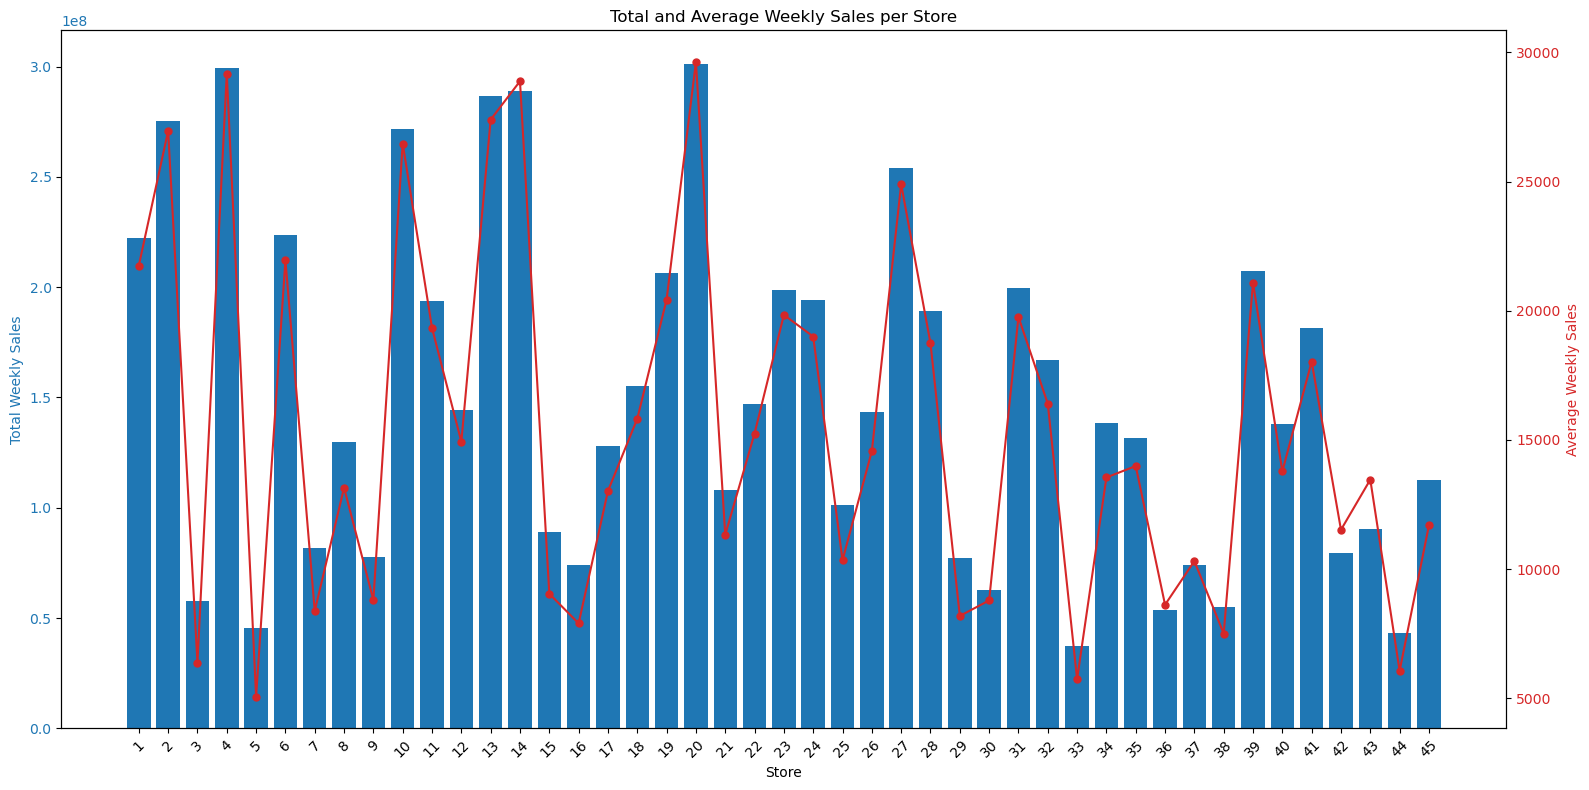

In [115]:
#Lets analyse the weekly sales with store wise:
#there are total 45 stores:
from pyspark.sql.functions import sum, avg

# Calculate total and average weekly sales per store
sales_by_store = df.groupBy("Store") \
    .agg(
        sum("Weekly_Sales").alias("Total_Weekly_Sales"),
        avg("Weekly_Sales").alias("Average_Weekly_Sales")
    ).orderBy("Store")

# Show the results
sales_by_store.show()

# Convert to Pandas DataFrame
sales_by_store_pd = sales_by_store.toPandas()

import matplotlib.pyplot as plt

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(16, 8))  # Adjusted for potentially better fit of labels

# Bar plot for total weekly sales
color = 'tab:blue'
ax1.set_xlabel('Store')
ax1.set_ylabel('Total Weekly Sales', color=color)
bars = ax1.bar(sales_by_store_pd['Store'], sales_by_store_pd['Total_Weekly_Sales'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Label x-axis with store numbers explicitly
ax1.set_xticks(sales_by_store_pd['Store'])
ax1.set_xticklabels(sales_by_store_pd['Store'], rotation=45)  # Rotate labels for better readability

# Create a twin axis for the average weekly sales
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Average Weekly Sales', color=color)  
line = ax2.plot(sales_by_store_pd['Store'], sales_by_store_pd['Average_Weekly_Sales'], color=color, marker='o', linestyle='-', markersize=5)
ax2.tick_params(axis='y', labelcolor=color)

# Adding a title and a legend
plt.title('Total and Average Weekly Sales per Store')
fig.tight_layout()  

# Show the plot
plt.show()


From above graph, it is can be seen that the Store 20 has the most number of weekly sales along with the average sales, whereas Store 33 has the lowest of all.

StatementMeta(spoolwalmart, 9, 12, Finished, Available, Finished)

+----+--------------------+--------------------+
|Dept|  Total_Weekly_Sales|Average_Weekly_Sales|
+----+--------------------+--------------------+
|   1|      1.2363877655E8|   19213.48508935509|
|   2| 2.806111744199999E8|  43607.020111888094|
|   3| 7.589244995000002E7|   11793.69851592852|
|   4|      1.6714674558E8|   25974.63023776224|
|   5|1.3560735862000003E8|  21368.950302552796|
|   6|2.8426508779999997E7|   4763.154956434316|
|   7|1.5547756276000005E8|  24161.237414141422|
|   8|1.9428078073000005E8|  30191.263516705523|
|   9|1.2839346687999998E8|  20219.443603149604|
|  10|1.1789738758000001E8|  18321.272351204352|
|  11| 9.332927637999994E7|  14505.638231271361|
|  12| 2.676012510000001E7|   4176.049485018728|
|  13|1.9732156994999996E8|   30663.80263403263|
|  14| 9.569466644999999E7|  14870.966037296035|
|  16| 9.167170216000003E7|   14252.44125621891|
|  17| 6.531981663000001E7|   10187.12049750468|
|  18|3.6899308110000014E7|  7611.2434220297055|
|  19|  6817225.7700

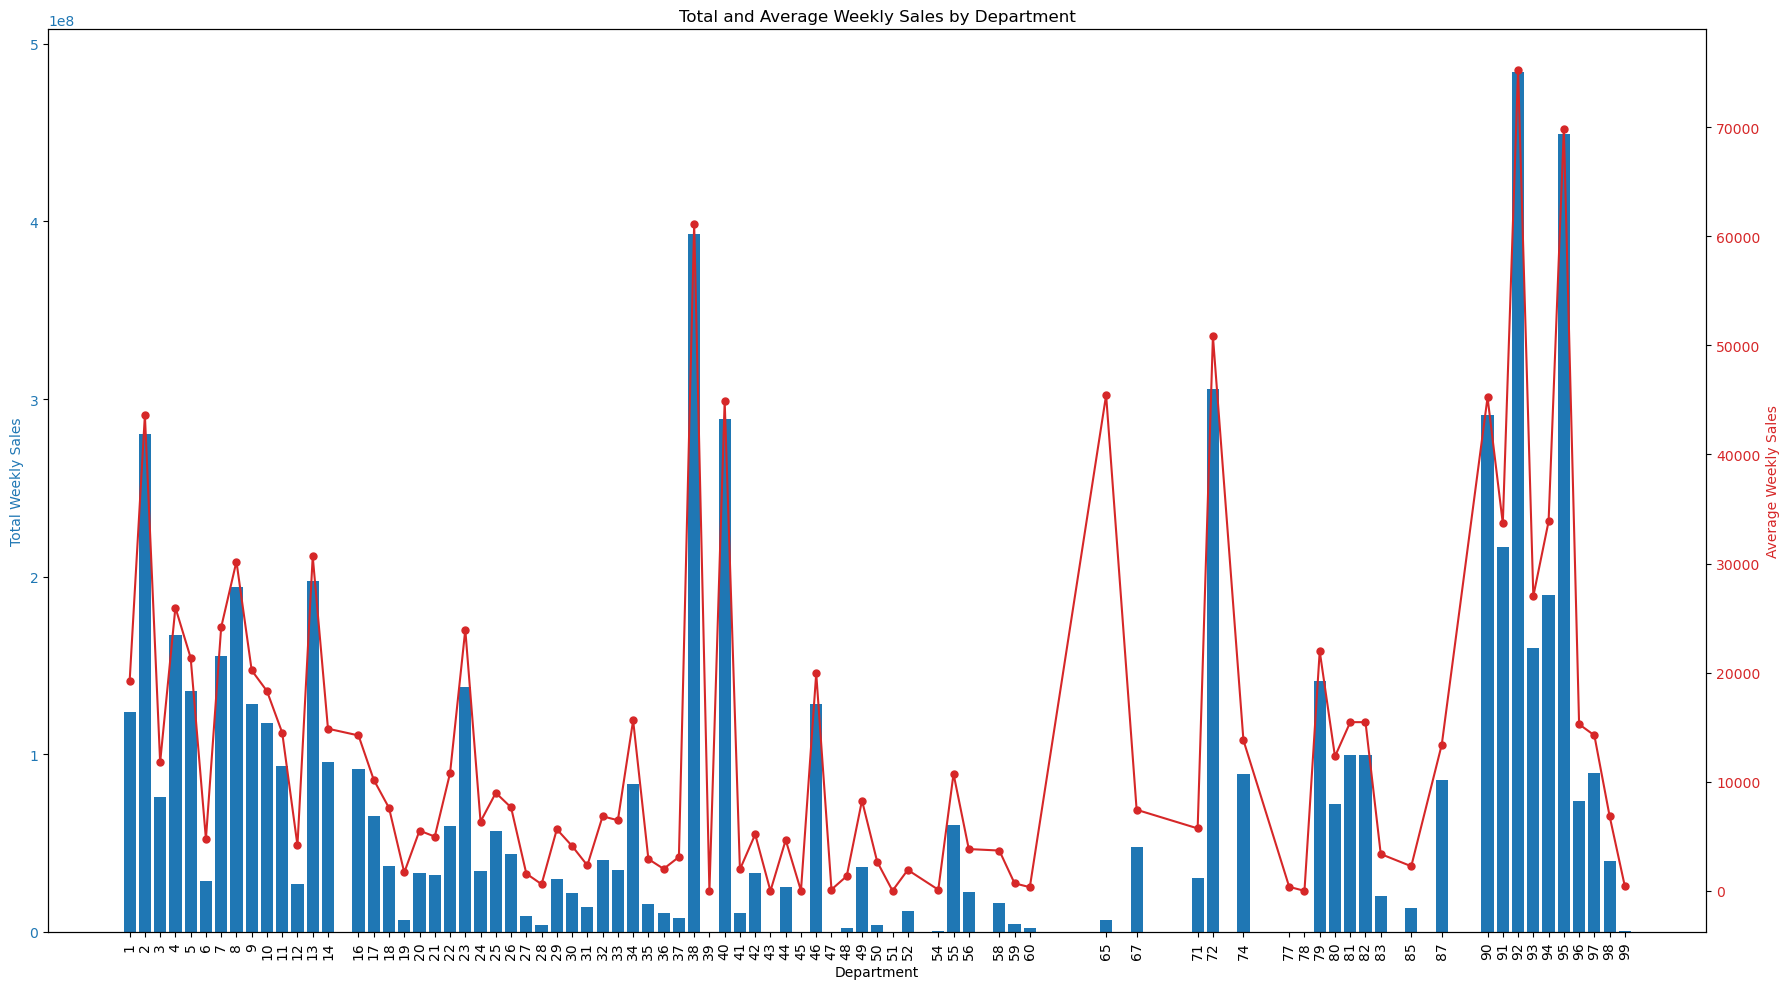

In [116]:
#Similar to above lets analyse the weekly sales department wise.
from pyspark.sql.functions import sum, avg

# Calculate total and average weekly sales per department
sales_by_department = df.groupBy("Dept") \
    .agg(
        sum("Weekly_Sales").alias("Total_Weekly_Sales"),
        avg("Weekly_Sales").alias("Average_Weekly_Sales")
    ).orderBy("Dept")

# Show the results
sales_by_department.show()

# Convert to Pandas DataFrame
sales_by_department_pd = sales_by_department.toPandas()

import matplotlib.pyplot as plt

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(18, 10))  # Adjusted size for clarity

# Bar plot for total weekly sales
color = 'tab:blue'
ax1.set_xlabel('Department')
ax1.set_ylabel('Total Weekly Sales', color=color)
bars = ax1.bar(sales_by_department_pd['Dept'], sales_by_department_pd['Total_Weekly_Sales'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Setting x-axis ticks explicitly to show all departments
ax1.set_xticks(sales_by_department_pd['Dept'])
ax1.set_xticklabels(sales_by_department_pd['Dept'], rotation=90)  # Rotate for readability

# Create a twin axis for the average weekly sales
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Average Weekly Sales', color=color)
line = ax2.plot(sales_by_department_pd['Dept'], sales_by_department_pd['Average_Weekly_Sales'], color=color, marker='o', linestyle='-', markersize=5)
ax2.tick_params(axis='y', labelcolor=color)

# Adding a title and a legend
plt.title('Total and Average Weekly Sales by Department')
fig.tight_layout()  

# Show the plot
plt.show()


From the above graph it is observed that, Department number 92 has recorded highest weekly sales and average weekly sales value.

StatementMeta(spoolwalmart, 9, 13, Finished, Available, Finished)

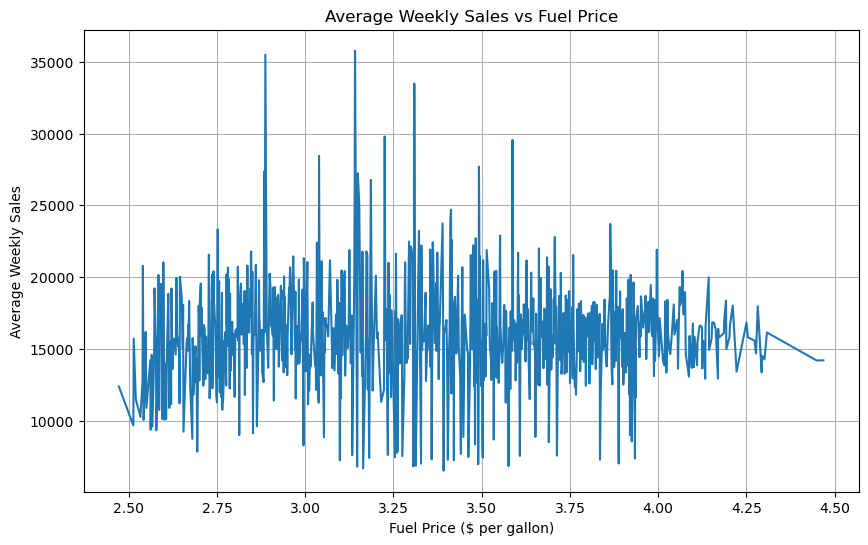

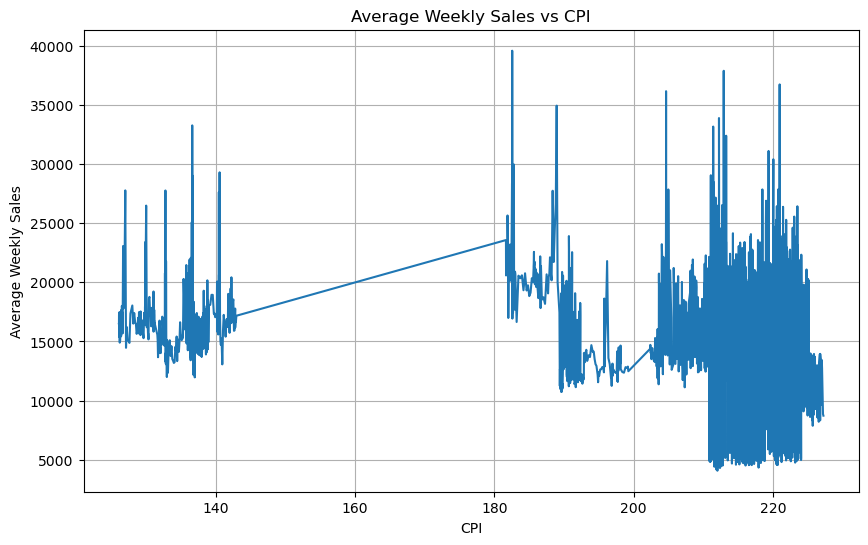

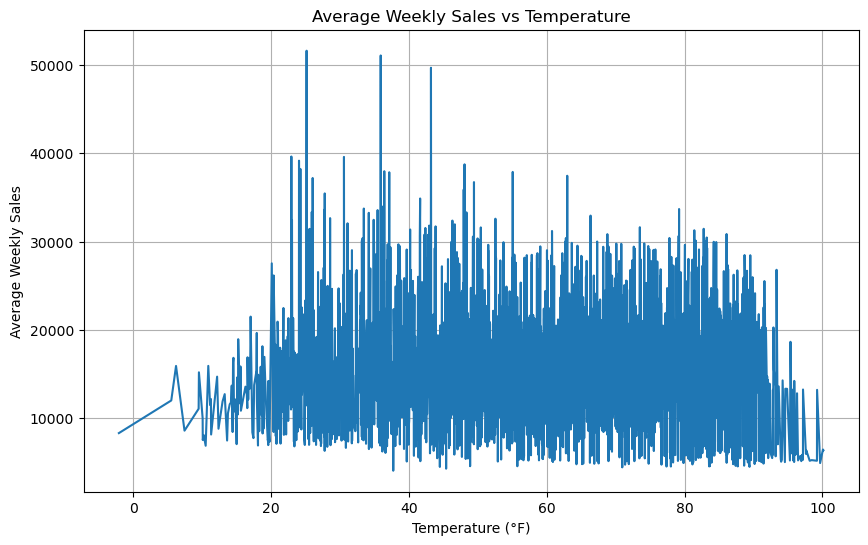

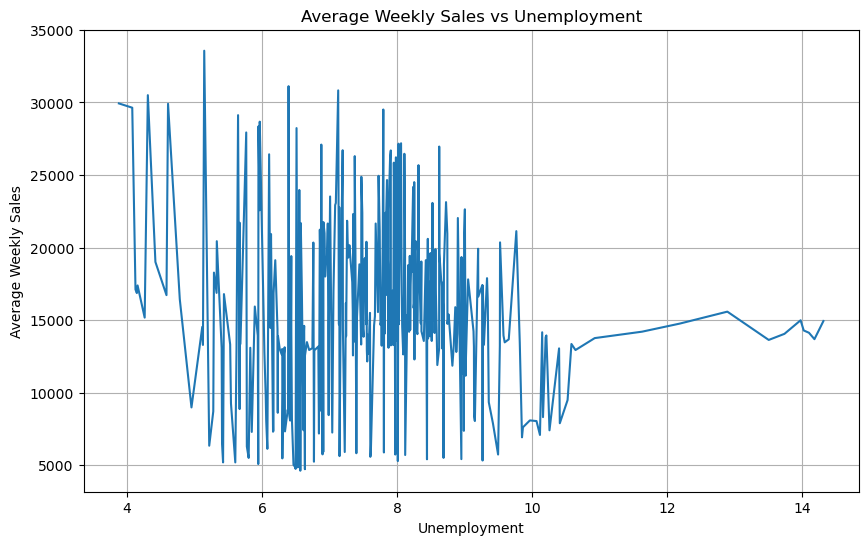

In [117]:
#lets now analyse the other parameters in the df such as petrol price, CPI and Temperature:
from pyspark.sql.functions import avg

# Assuming df has columns "Fuel_Price" and "Weekly_Sales"
fuel_price_sales = df.groupBy("Fuel_Price").agg(avg("Weekly_Sales").alias("Avg_Weekly_Sales"))

# Sort by Fuel Price for better visualization
fuel_price_sales = fuel_price_sales.orderBy("Fuel_Price")

fuel_price_sales_pd = fuel_price_sales.toPandas()

import matplotlib.pyplot as plt

# Plotting the average weekly sales vs. fuel price
plt.figure(figsize=(10, 6))  # Set the figure size or adjust as needed
plt.plot(fuel_price_sales_pd['Fuel_Price'], fuel_price_sales_pd['Avg_Weekly_Sales'], linestyle='-')
plt.title('Average Weekly Sales vs Fuel Price')
plt.xlabel('Fuel Price ($ per gallon)')
plt.ylabel('Average Weekly Sales')
plt.grid(True)  # Optional: Adds a grid for easier visualization
plt.show()

#Analyse the CPI parameter for sales:
# Aggregate Weekly_Sales by CPI
cpi_sales = df.groupBy("CPI").agg(avg("Weekly_Sales").alias("Avg_Weekly_Sales"))

# Sort by CPI for better visualization
cpi_sales = cpi_sales.orderBy("CPI")

cpi_sales_pd = cpi_sales.toPandas()

# Plotting the average weekly sales vs. CPI
plt.figure(figsize=(10, 6))
plt.plot(cpi_sales_pd['CPI'], cpi_sales_pd['Avg_Weekly_Sales'], linestyle='-')
plt.title('Average Weekly Sales vs CPI')
plt.xlabel('CPI')
plt.ylabel('Average Weekly Sales')
plt.grid(True)
plt.show()

#Analyse Temperature parameter for sales:
# Aggregate Weekly_Sales by Temperature
temp_sales = df.groupBy("Temperature").agg(avg("Weekly_Sales").alias("Avg_Weekly_Sales"))

# Sort by Temperature for better visualization
temp_sales = temp_sales.orderBy("Temperature")

temp_sales_pd = temp_sales.toPandas()

# Plotting the average weekly sales vs. Temperature
plt.figure(figsize=(10, 6))
plt.plot(temp_sales_pd['Temperature'], temp_sales_pd['Avg_Weekly_Sales'], linestyle='-')
plt.title('Average Weekly Sales vs Temperature')
plt.xlabel('Temperature (°F)')
plt.ylabel('Average Weekly Sales')
plt.grid(True)
plt.show()

#Analyse the unemployment parameter:

# Aggregate Weekly_Sales by unemployment
temp_sales = df.groupBy("Unemployment").agg(avg("Weekly_Sales").alias("Avg_Weekly_Sales"))

# Sort by Unemployment for better visualization
temp_sales = temp_sales.orderBy("Unemployment")

temp_sales_pd = temp_sales.toPandas()

# Plotting the average weekly sales vs. Unemployment
plt.figure(figsize=(10, 6))
plt.plot(temp_sales_pd['Unemployment'], temp_sales_pd['Avg_Weekly_Sales'], linestyle='-')
plt.title('Average Weekly Sales vs Unemployment')
plt.xlabel('Unemployment')
plt.ylabel('Average Weekly Sales')
plt.grid(True)
plt.show()


From the above graphs of average weekly sales vs CPI, fuel price, temperature and unemployment parameters no significant patterns are observed. 

Lets analyse the weekly sales according to the weeks, months, and years.

In [118]:
from pyspark.sql.functions import weekofyear, month, year, to_date, avg

# Convert 'Date' to a Date type if it's not already
df = df.withColumn("Date", to_date("Date", "yyyy-MM-dd"))

# Extract week, month, and year from the 'Date' column
df = df.withColumn("week", weekofyear("Date")) \
       .withColumn("month", month("Date")) \
       .withColumn("year", year("Date"))

# Group by month and calculate average weekly sales
monthly_sales = df.groupBy("month").agg(avg("Weekly_Sales").alias("Avg_Weekly_Sales_Month"))

# Sort by month for better readability (optional)
monthly_sales = monthly_sales.orderBy("month")
monthly_sales.show()

# Group by year and calculate average weekly sales
yearly_sales = df.groupBy("year").agg(avg("Weekly_Sales").alias("Avg_Weekly_Sales_Year"))

# Sort by year for better readability (optional)
yearly_sales = yearly_sales.orderBy("year")
yearly_sales.show()

# Group by week and calculate average weekly sales
weekly_sales = df.groupBy("week").agg(avg("Weekly_Sales").alias("Avg_Weekly_Sales_Week"))

# Sort by average weekly sales descending to find top weeks
top_weekly_sales = weekly_sales.orderBy("Avg_Weekly_Sales_Week", ascending=False)
top_weekly_sales.show(5)  # Show top 5 weeks



StatementMeta(spoolwalmart, 9, 14, Finished, Available, Finished)

+-----+----------------------+
|month|Avg_Weekly_Sales_Month|
+-----+----------------------+
|    1|     14182.23915316392|
|    2|    16048.701193069579|
|    3|    15464.817696963371|
|    4|     15696.43518890587|
|    5|    15845.556197952206|
|    6|    16397.605477074594|
|    7|    15905.472423715932|
|    8|    16113.800072014285|
|    9|    15147.216062025629|
|   10|    15279.182117102988|
|   11|     17534.96427528233|
|   12|     19425.79860683616|
+-----+----------------------+

+----+---------------------+
|year|Avg_Weekly_Sales_Year|
+----+---------------------+
|2010|   16318.648284805784|
|2011|   16007.797985092175|
|2012|   15748.265003700519|
+----+---------------------+

+----+---------------------+
|week|Avg_Weekly_Sales_Week|
+----+---------------------+
|  51|   26454.164115577907|
|  47|   22269.601759165835|
|  50|   20478.421135561908|
|  49|   18731.794851801962|
|  22|    16856.65024041213|
+----+---------------------+
only showing top 5 rows



From above analysis, it is observed that, year 2010 has the highest average weekly sales than 2011 and 2012. Top 5 sales averages by weekly belongs to 1-2 weeks before Christmas, Thanksgiving, Black Friday and end of May, when the schools are closed.

For training a machine learning model to forecast the weekly sales, there is a need to perform feature selection for optimal model performance and reliable results. To this end, use of intrinsic method of feature selection with the help of Random forest regressor is performed further.

In [119]:
print(df.columns)
df.printSchema()

StatementMeta(spoolwalmart, 9, 15, Finished, Available, Finished)

['Store', 'Date', 'Dept', 'Weekly_Sales', 'IsHoliday', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'Super_Bowl', 'Labor_Day', 'Thanksgiving', 'Christmas', 'week', 'month', 'year']
root
 |-- Store: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Dept: integer (nullable = true)
 |-- Weekly_Sales: double (nullable = true)
 |-- IsHoliday: boolean (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Fuel_Price: double (nullable = true)
 |-- MarkDown1: double (nullable = true)
 |-- MarkDown2: double (nullable = true)
 |-- MarkDown3: double (nullable = true)
 |-- MarkDown4: double (nullable = true)
 |-- MarkDown5: double (nullable = true)
 |-- CPI: double (nullable = true)
 |-- Unemployment: double (nullable = true)
 |-- Type: string (nullable = true)
 |-- Size: integer (nullable = true)
 |-- Super_Bowl: boolean (nullable = false)
 |-- Labor_Day: boolean (nullable = false)
 |

In [120]:
# Create a new DataFrame named encoded_df by selecting all columns from df
encoded_df = df.select(*df.columns)

encoded_df.printSchema()


StatementMeta(spoolwalmart, 9, 16, Finished, Available, Finished)

root
 |-- Store: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Dept: integer (nullable = true)
 |-- Weekly_Sales: double (nullable = true)
 |-- IsHoliday: boolean (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Fuel_Price: double (nullable = true)
 |-- MarkDown1: double (nullable = true)
 |-- MarkDown2: double (nullable = true)
 |-- MarkDown3: double (nullable = true)
 |-- MarkDown4: double (nullable = true)
 |-- MarkDown5: double (nullable = true)
 |-- CPI: double (nullable = true)
 |-- Unemployment: double (nullable = true)
 |-- Type: string (nullable = true)
 |-- Size: integer (nullable = true)
 |-- Super_Bowl: boolean (nullable = false)
 |-- Labor_Day: boolean (nullable = false)
 |-- Thanksgiving: boolean (nullable = false)
 |-- Christmas: boolean (nullable = false)
 |-- week: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)



In [121]:
#Convert the categorical variable to numerical such as True/False to 1/0:
from pyspark.sql.functions import when

# Map 'Type' from 'A', 'B', 'C' to 1, 2, 3 using when().otherwise() chain
encoded_df = encoded_df.withColumn("Type", 
    when(col("Type") == "A", 1).\
    when(col("Type") == "B", 2).\
    when(col("Type") == "C", 3).\
    otherwise(0))  # This handles any unexpected values by assigning them 0

# Print schema to confirm the data type of 'Type' column
encoded_df.printSchema()

# Show the transformed DataFrame to verify the changes
encoded_df.show(5)

StatementMeta(spoolwalmart, 9, 17, Finished, Available, Finished)

root
 |-- Store: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Dept: integer (nullable = true)
 |-- Weekly_Sales: double (nullable = true)
 |-- IsHoliday: boolean (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Fuel_Price: double (nullable = true)
 |-- MarkDown1: double (nullable = true)
 |-- MarkDown2: double (nullable = true)
 |-- MarkDown3: double (nullable = true)
 |-- MarkDown4: double (nullable = true)
 |-- MarkDown5: double (nullable = true)
 |-- CPI: double (nullable = true)
 |-- Unemployment: double (nullable = true)
 |-- Type: integer (nullable = false)
 |-- Size: integer (nullable = true)
 |-- Super_Bowl: boolean (nullable = false)
 |-- Labor_Day: boolean (nullable = false)
 |-- Thanksgiving: boolean (nullable = false)
 |-- Christmas: boolean (nullable = false)
 |-- week: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)

+-----+----------+----+------------+---------+-----------+---------

In [122]:
#lets visualise the correlation between the features:
#for this lets drop the different types of Holiday columns and only keep the IsHoliday. # Dropping features which might create collinearity and not so correlational to weekly_sales based on the correlational matrix:
# List of columns to drop
drop_col = ['Super_Bowl', 'Labor_Day', 'Thanksgiving', 'Christmas','Type_Index','Type_Vec']

# Drop the columns
new_df = encoded_df.drop(*drop_col)

from pyspark.sql.functions import dayofmonth
# Add a new column 'day' that extracts the day from the 'Date' column
new_df = new_df.withColumn('day', dayofmonth('Date'))

#creating a time series df already for later use
time_series_df = new_df

# Drop the 'Date' column
#new_df = new_df.drop('Date')

from pyspark.sql.functions import when

# Convert 'IsHoliday' from boolean to integer (1 for True, 0 for False)
new_df = new_df.withColumn('IsHoliday', when(new_df['IsHoliday'], 1).otherwise(0))

#Now that the process of cleaning and transforming the dataset is complete, we can persist the cleaned data to Azure data lake gen 2 in the form of csv:
# Specify the path to store the DataFrame in Azure Data Lake Storage Gen2
output_path = "/mnt/walamrt-data-transform-mount/Preprocessed Data/"

# Write the DataFrame to the Data Lake as CSV files with headers
new_df.write.format("csv") \
    .option("header", "true") \
    .mode("overwrite") \
    .save(output_path)

# Print a confirmation message
print("Data successfully written to Azure Data Lake Storage Gen2 with headers.")

# # Convert PySpark DataFrame to Pandas DataFrame
# pandas_df = new_df.toPandas()

# # Calculate the correlation matrix
# correlation_matrix = pandas_df.corr()

# import seaborn as sns
# import matplotlib.pyplot as plt

# # Set up the matplotlib figure
# plt.figure(figsize=(10, 8))

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

# # Add a title
# plt.title('Correlation Matrix of Features')

# #print the new_df:
# new_df.show(5)

# # Show the plot
# plt.show()



StatementMeta(spoolwalmart, 9, 18, Finished, Available, Finished)

Data successfully written to Azure Data Lake Storage Gen2 with headers.


From the above correlation matrix it can be obbsered that the, Type_index and Type are creating a collinearity hence need to drop Type_Index as they represent similar value. MarkDown4 and MarkDown1 have high correlation. MarkDown1 and MarkDown5 have positive correlation with Size. They could be exclusive offers for bigger stores. MarkDown2 have negative correlation with Temperature. MarkDown2 could be offers during winters / holiday offers.

In [96]:
# List of columns to drop 
drop_col = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']

# Drop the columns
new_df = new_df.drop(*drop_col)

StatementMeta(spoolwalmart, 8, 18, Finished, Available, Finished)

StatementMeta(spoolwalmart, 8, 19, Finished, Available, Finished)

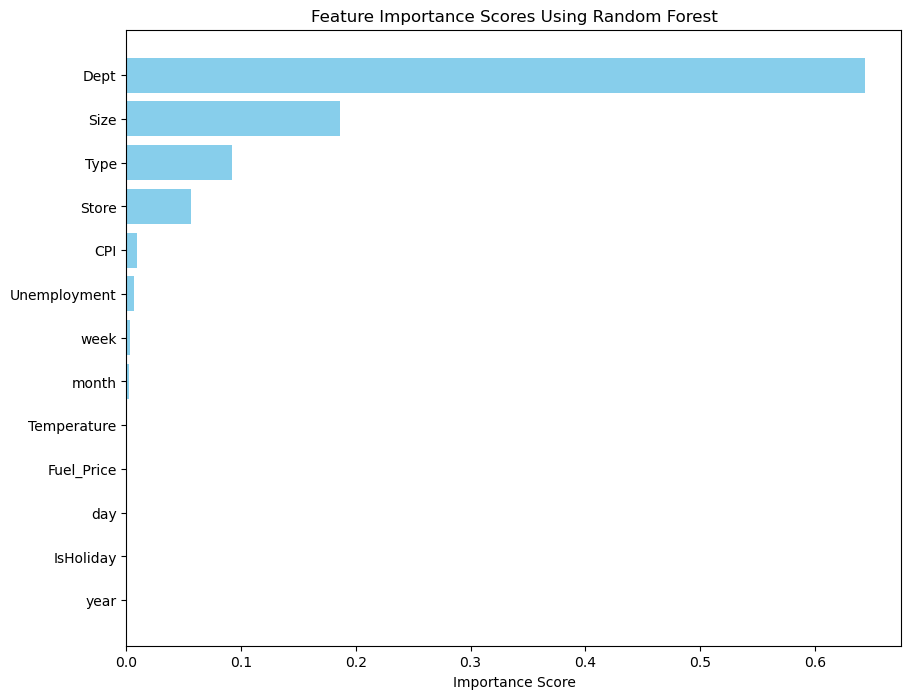

In [97]:
#Now using the Random forest regressor for analysing the feature importance:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline

# 'new_df' has all the necessary preprocessed columns
feature_columns = [col for col in new_df.columns if col != 'Weekly_Sales']  # all columns except the target

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# This will transform the data and result in a new DataFrame with all features in a vector column
df_assembled = assembler.transform(new_df).select("features", "Weekly_Sales")

# Initialize the RandomForest model
rf = RandomForestRegressor(featuresCol="features", labelCol="Weekly_Sales", numTrees=100)

# Fit the model
model = rf.fit(df_assembled)

import pandas as pd
import matplotlib.pyplot as plt

# Feature importance scores
importances = model.featureImportances

# Map feature indices to names and plot
feature_names = assembler.getInputCols()
importance_scores = [(feature_names[i], importances[i]) for i in range(len(feature_names))]

# Convert to DataFrame for easier handling
df_importances = pd.DataFrame(importance_scores, columns=["Feature", "Importance"]).sort_values(by="Importance", ascending=True)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(df_importances['Feature'], df_importances['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance Scores Using Random Forest')
plt.show()

